In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#%cd /content/gdrive/My\ Drive/classification/data
#!wget https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/5a5a3b1a-0b1d-46bc-bff2-0420599d351b .


In [ ]:
#!unzip cella_vision_data.zip 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from PIL import Image

from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
batch_size = 4
img_height = 360
img_width = 363
data_dir='/content/gdrive/My Drive/classification/data/PBC_dataset_normal_DIB/'

In [ ]:
'''

rbc_list = glob(os.path.join('/content/gdrive/My Drive/classification/data/rbc/*.jpg'))

ww = 96
hh = 96
color = (0,0,0)
for a_rbc in rbc_list:
  print(a_rbc)
  im = Image.open(a_rbc)
  img = np.full((hh,ww,3),(0,0,0), dtype=np.uint8)
  img[24:24+48, 24:24+48] = im
  plt.imsave(a_rbc,img)

'''

"\n\nrbc_list = glob(os.path.join('/content/gdrive/My Drive/classification/data/rbc/*.jpg'))\n\nww = 96\nhh = 96\ncolor = (0,0,0)\nfor a_rbc in rbc_list:\n  print(a_rbc)\n  im = Image.open(a_rbc)\n  img = np.full((hh,ww,3),(0,0,0), dtype=np.uint8)\n  img[24:24+48, 24:24+48] = im\n  plt.imsave(a_rbc,img)\n\n"

In [ ]:
files_list = glob(os.path.join('/content/gdrive/My Drive/classification/data/PBC_dataset_normal_DIB/*/*.jpg'))
len(files_list)

17092

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.7,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17093 files belonging to 8 classes.
Using 5128 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.057,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17093 files belonging to 8 classes.
Using 974 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print('Number of val batches: %d' % tf.data.experimental.cardinality(val_ds))

Number of test batches: 48
Number of val batches: 196


In [ ]:
class_names = train_ds.class_names
print(class_names)

['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


In [ ]:
'''
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
'''

'\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(10, 10))\nfor images, labels in train_ds.take(1):\n  for i in range(4):\n    ax = plt.subplot(2, 2, i + 1)\n    plt.imshow(images[i].numpy().astype("uint8"))\n    plt.title(class_names[labels[i]])\n    plt.axis("off")\n'

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 360, 363, 3)
(4,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.028578658 1.0


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


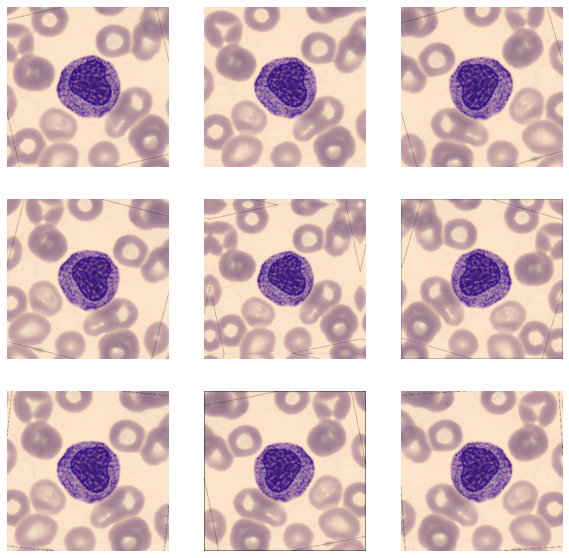

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(4):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:

num_classes = 8

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



In [ ]:
#model.build(input_shape=(img_width, img_height, 3))

#from keras.optimizers import Adam
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)
#learning_rate = 0.1
#decay_rate = learning_rate / epochs
#momentum = 0.8
#sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
image_shape = (None, img_height, img_width,3)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.build(image_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 360, 363, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 360, 363, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 360, 363, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 180, 181, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 181, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)       

In [ ]:
epochs=25
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/25
1282/1282 [==============================] - 744s 580ms/step - loss: 1.1129 - accuracy: 0.5893 - val_loss: 0.5108 - val_accuracy: 0.8325
Epoch 2/25
1282/1282 [==============================] - 22s 17ms/step - loss: 0.5170 - accuracy: 0.8120 - val_loss: 0.3289 - val_accuracy: 0.8951
Epoch 3/25
1282/1282 [==============================] - 21s 17ms/step - loss: 0.3666 - accuracy: 0.8730 - val_loss: 0.2768 - val_accuracy: 0.9015
Epoch 4/25
1282/1282 [==============================] - 22s 17ms/step - loss: 0.3119 - accuracy: 0.8957 - val_loss: 0.1876 - val_accuracy: 0.9322
Epoch 5/25
1282/1282 [==============================] - 22s 17ms/step - loss: 0.2775 - accuracy: 0.9035 - val_loss: 0.2355 - val_accuracy: 0.9143
Epoch 6/25
1282/1282 [==============================] - 22s 17ms/step - loss: 0.2201 - accuracy: 0.9234 - val_loss: 0.2833 - val_accuracy: 0.8939
Epoch 7/25
1282/1282 [==============================] - 22s 17ms/step - loss: 0.2184 - accuracy: 0.9284 - val_loss: 0.1739

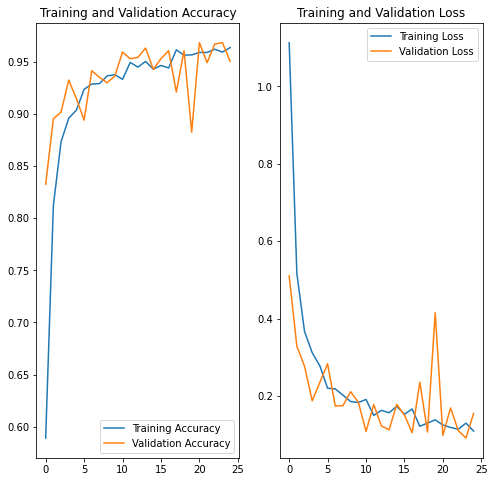

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#model.save(os.path.join('/content/gdrive/My Drive/classification/','my_model_v2.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/classification/my_model_v2.model/assets


In [ ]:
img = keras.preprocessing.image.load_img('/content/gdrive/My Drive/classification/BA_47.jpg', target_size=(img_height, img_width))##basiphil
model = keras.models.load_model(os.path.join('/content/gdrive/My Drive/classification','my_model_v2.model'))

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to basophil with a 99.99 percent confidence.


In [ ]:
label_test = np.ndarray([])
y_pred_series = np.ndarray([])
i=0

for element in test_dataset:
  y_pred = model.predict(element[0])
  y_pred = y_pred.argmax(axis=-1)
  y_pred_series = np.append(y_pred_series,y_pred)
  lbl=element[1].numpy()
  label_test=np.append(label_test,lbl)
  i = i+1


In [ ]:
import itertools    


def plot_confusion_matrix(cm, class_names):
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    #plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return 0


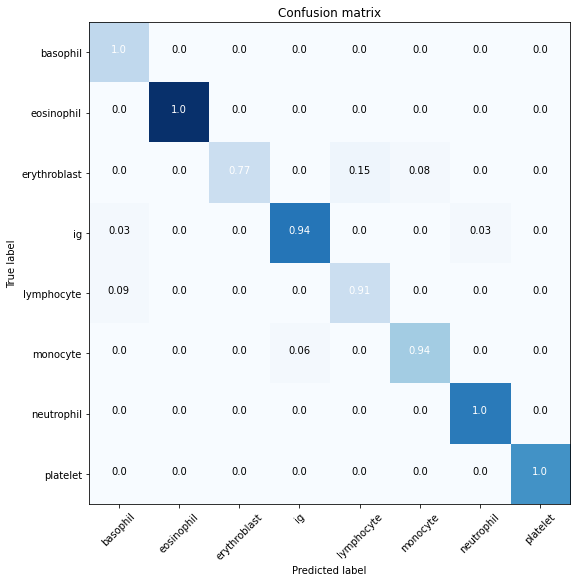

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label_test,y_pred_series)

plot_confusion_matrix(cm, class_names)